<p align="center" style="font-size:32px;">
  <strong>Credit Card Fraud</strong><br>
  Arunansh Yadav
</p>

# <a id="1">Loading libraries </a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, AdaBoostClassifier

from sklearn.metrics import roc_auc_score,accuracy_score, precision_score

# <a id="2">About the Dataset</a>  

The datasets contains transactions made by credit cards in **September 2013** by european cardholders. This dataset presents transactions that occurred in two days, where we have **492 frauds** out of **284,807 transactions**. The dataset is **highly unbalanced**, the **positive class (frauds)** account for **0.172%** of all transactions.  

It contains only numerical input variables which are the result of a **PCA transformation**.   

Due to confidentiality issues, there are not provided the original features and more background information about the data.  

* Features **V1**, **V2**, ... **V28** are the **principal components** obtained with **PCA**;  
* The only features which have not been transformed with PCA are **Time** and **Amount**. Feature **Time** contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature **Amount** is the transaction Amount, this feature can be used for example-dependant cost-senstive learning.   
* Feature **Class** is the response variable and it takes value **1** in case of fraud and **0** otherwise.  



In [2]:
# read the dataset
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# <a id="3">First Know our dataset</a>

In [3]:
# Structure of the dataset 
print("Credit card fraud detection dataset contains : rows",df.shape[0], "and columns :", df.shape[1])

Credit card fraud detection dataset contains : rows 284807 and columns : 31


In [4]:
# Missing values 
Missing_values = df.isnull().sum().sort_values(ascending = False)
Missing_percent = (df.isnull().sum()/df.shape[0]*100).sort_values(ascending = False)
pd.concat([Missing_values, Missing_percent], axis=1, keys=['Missing_values', 'Missing_percent']).transpose()

,Time,V16,Amount,V28,V27,V26,V25,V24,V23,V22,...,V10,V9,V8,V7,V6,V5,V4,V3,V2,Class
Missing_values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Missing_percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There is no missing data in the entire dataset.

In [5]:
# Checking Duplicates Values
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 1081


Dataset contains 1081 duplicates rows.

In [6]:
# Drop Duplicates
data = df.drop_duplicates()
print("After dropping duplicates values the dataset contains : rows",df.shape[0], "and columns :", df.shape[1])

After dropping duplicates values the dataset contains : rows 284807 and columns : 31


In [8]:
import plotly.graph_objects as go
import plotly.express as px

## Is the data Unbalanced?

In [9]:
# Create a subplot layout
temp =df["Class"].value_counts()
temp_df = pd.DataFrame({'Class': temp.index,'values':temp.values})

trace = go.Bar(
    x = temp_df["Class"], y = temp_df["values"],
    name = """Credit Card Fraud Class -(Not fraud = 0, Fraud = 1)""",
    marker=dict(color = "skyblue"),
    text = temp_df["values"]
)
data = [trace]
layout = dict(title = """Credit Card Fraud Class - (Not fraud = 0, Fraud = 1)""",
              xaxis = dict(title = "Class", showticklabels = True),
              hovermode = 'closest', width = 500
              )
fig = dict(data = data, layout = layout)
iplot(fig, filename = "class")

Only **492** (or **0.172%**) of transaction are fraudulent. That means the data is highly unbalanced with respect with target variable **Class**.

# <a id="4">Exploratory Data Analysis. </a>

## Transactions in time

In [10]:
# Separate the dataset based on class values 1 and 0, and perform some EDA tasks on each class.
class_0 = df.loc[df['Class'] == 0]["Time"]
class_1 = df.loc[df['Class'] == 1]["Time"]

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

Fraudulent transactions have a distribution more even than valid transactions - are equaly distributed in time, including the low real transaction times, during night in Europe timezone.

Let's look into more details to the time distribution of both classes transaction, as well as to aggregated values of transaction count and amount, per hour. We assume (based on observation of the time distribution of transactions) that the time unit is second.

In [11]:
df['Hour'] = df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df2 = pd.DataFrame(tmp)
df2.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df2.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


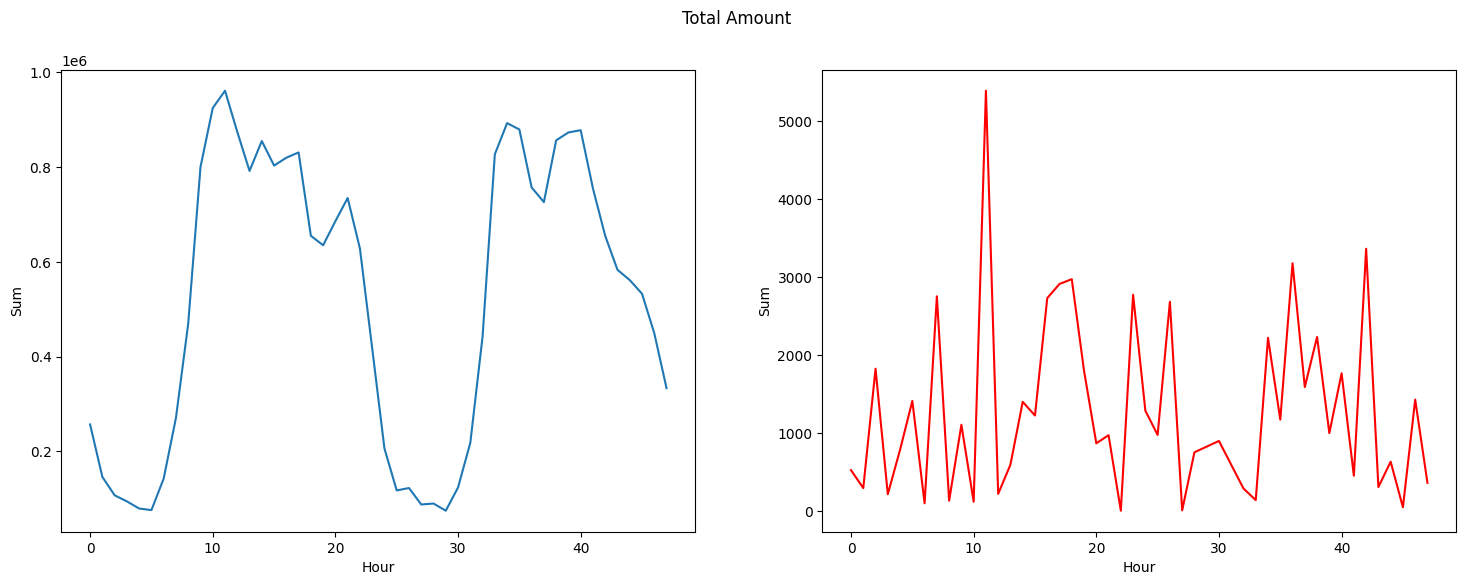

In [12]:
fig,(ax1, ax2) = plt.subplots(ncols = 2, figsize = (18,6))
s = sns.lineplot(ax=ax1, x = "Hour", y = "Sum", data=df2.loc[df2.Class==0])
s = sns.lineplot(ax=ax2, x = "Hour", y = "Sum", data=df2.loc[df2.Class==1], color = "red")
plt.suptitle("Total Amount")
plt.show()

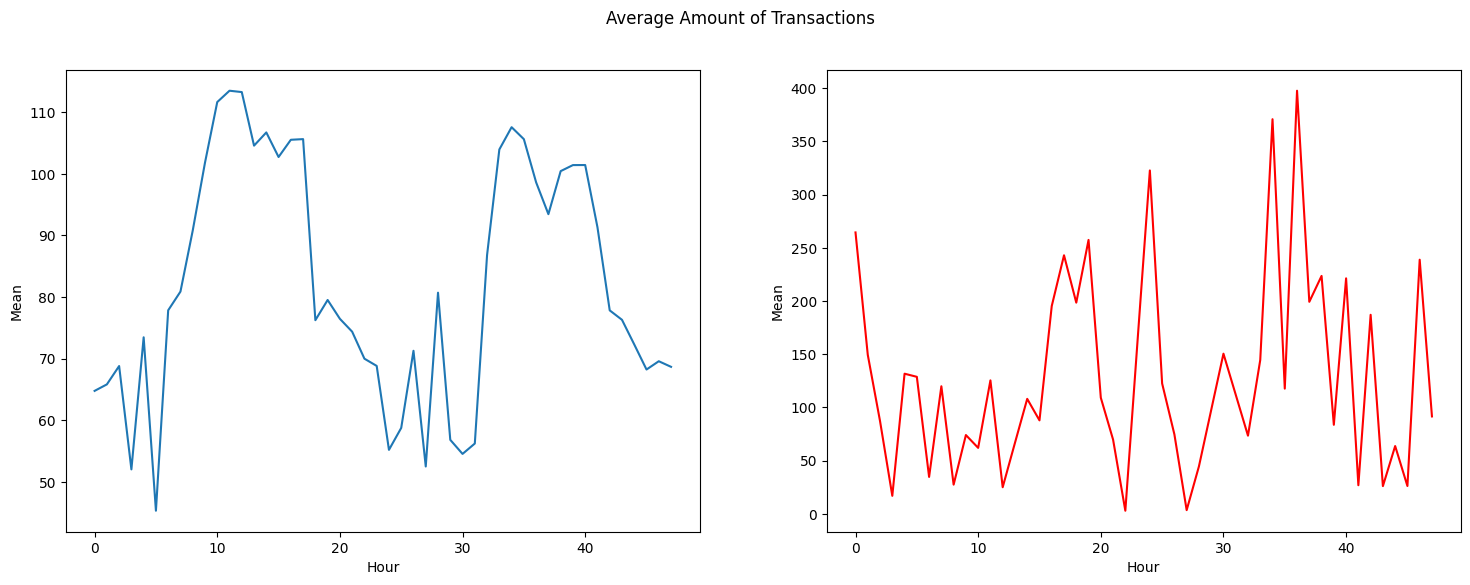

In [13]:
fig,(ax1, ax2) = plt.subplots(ncols = 2, figsize = (18,6))
s = sns.lineplot(ax=ax1, x = "Hour", y = "Mean", data=df2.loc[df2.Class==0])
s = sns.lineplot(ax=ax2, x = "Hour", y = "Mean", data=df2.loc[df2.Class==1], color = "red")
plt.suptitle("Average Amount of Transactions")
plt.show()

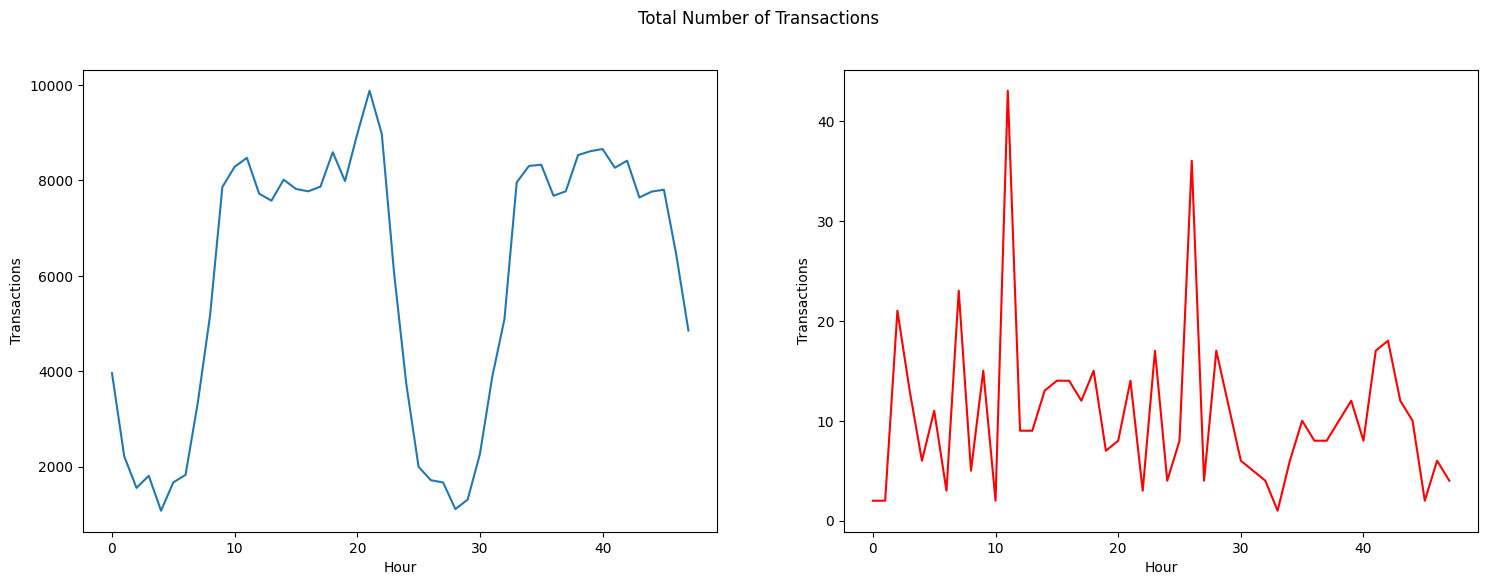

In [14]:
fig,(ax1, ax2) = plt.subplots(ncols = 2, figsize = (18,6))
s = sns.lineplot(ax=ax1, x = "Hour", y = "Transactions", data=df2.loc[df2.Class==0])
s = sns.lineplot(ax=ax2, x = "Hour", y = "Transactions", data=df2.loc[df2.Class==1], color = "red")
plt.suptitle("Total Number of Transactions")
plt.show()

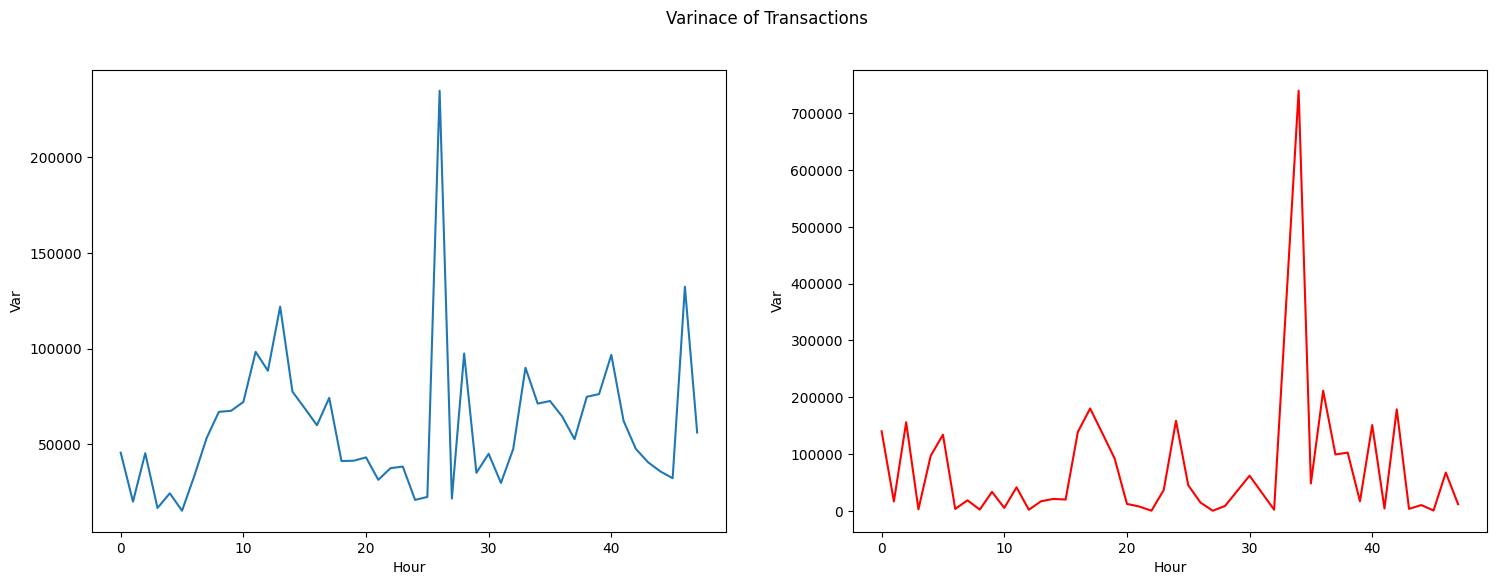

In [15]:
fig,(ax1, ax2) = plt.subplots(ncols = 2, figsize = (18,6))
s = sns.lineplot(ax=ax1, x = "Hour", y = "Var", data=df2.loc[df2.Class==0])
s = sns.lineplot(ax=ax2, x = "Hour", y = "Var", data=df2.loc[df2.Class==1], color = "red")
plt.suptitle("Varinace of Transactions")
plt.show()

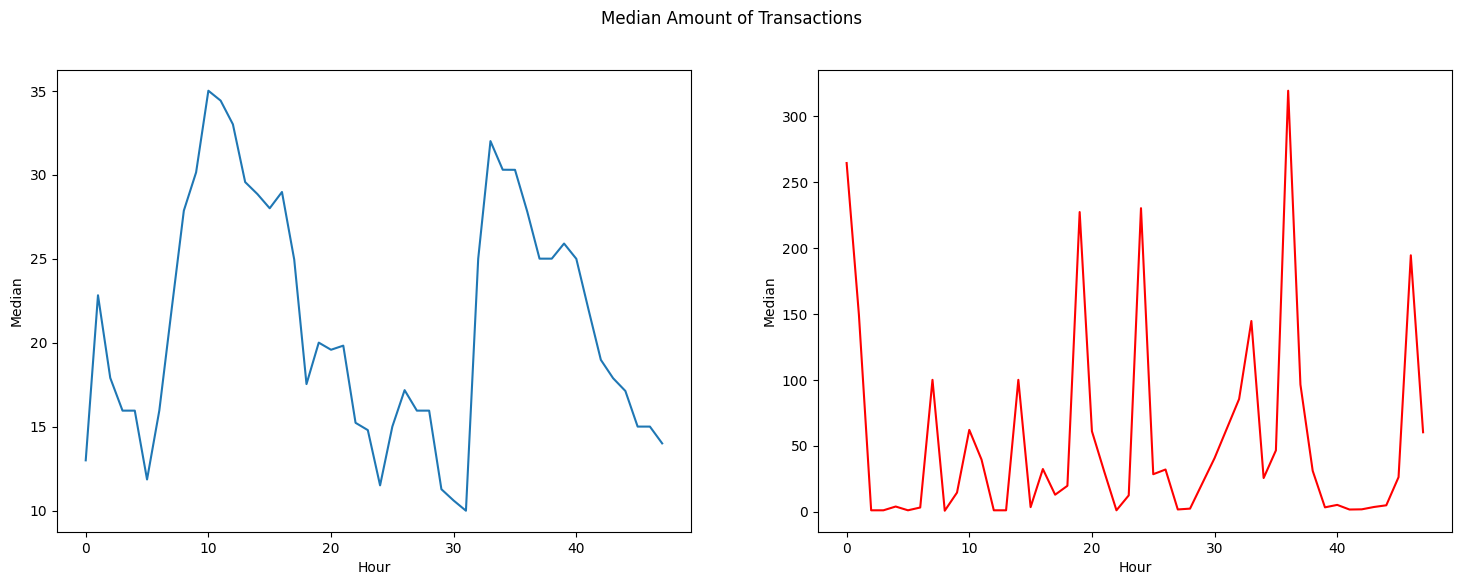

In [16]:
fig,(ax1, ax2) = plt.subplots(ncols = 2, figsize = (18,6))
s = sns.lineplot(ax=ax1, x = "Hour", y = "Median", data=df2.loc[df2.Class==0])
s = sns.lineplot(ax=ax2, x = "Hour", y = "Median", data=df2.loc[df2.Class==1], color = "red")
plt.suptitle("Median Amount of Transactions")
plt.show()

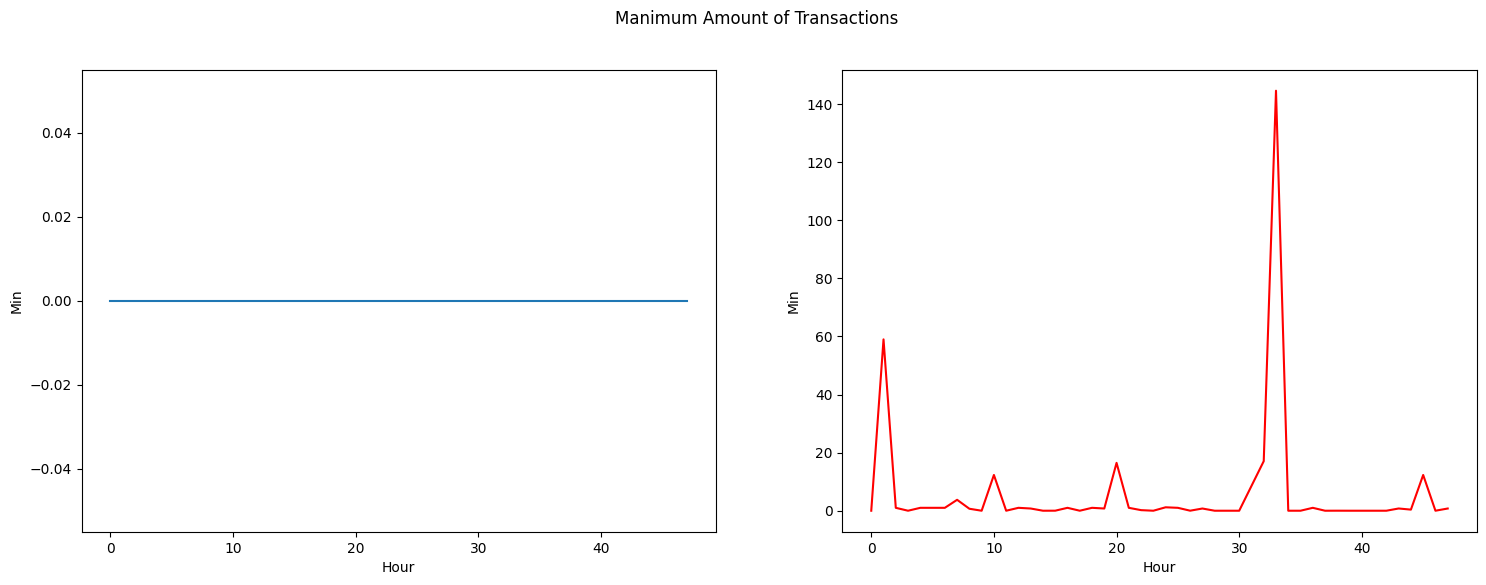

In [17]:
fig,(ax1, ax2) = plt.subplots(ncols = 2, figsize = (18,6))
s = sns.lineplot(ax=ax1, x = "Hour", y = "Min", data=df2.loc[df2.Class==0])
s = sns.lineplot(ax=ax2, x = "Hour", y = "Min", data=df2.loc[df2.Class==1], color = "red")
plt.suptitle("Manimum Amount of Transactions")
plt.show()

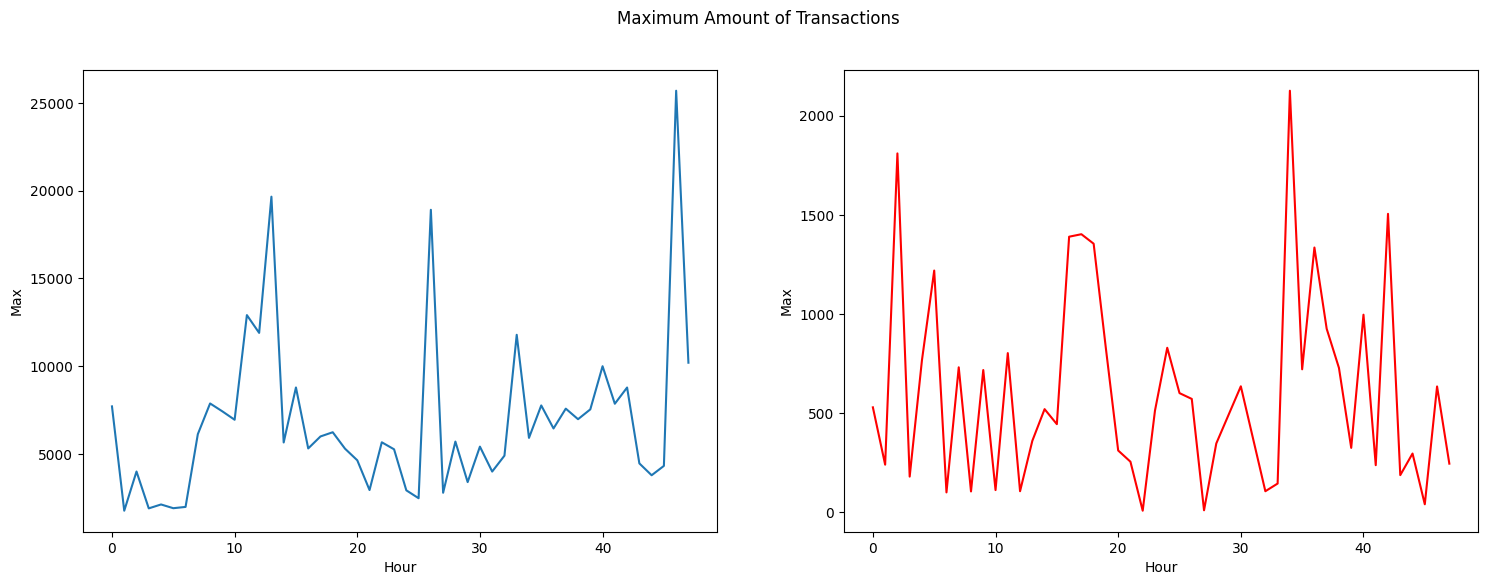

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df2.loc[df2.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df2.loc[df2.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions")
plt.show();

## Transactions amount

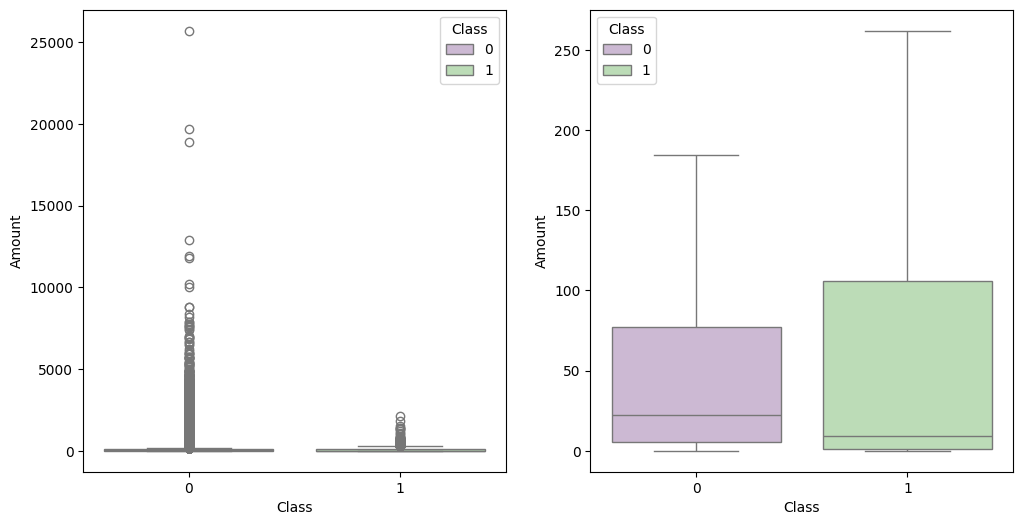

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=df, palette="PRGn",showfliers=False)
plt.show();

In [20]:
# "Amount Description of Class 0 (Not Fraud)"
temp = df[["Amount", "Class"]].copy()
class0 = temp.loc[temp["Class"] == 0]["Amount"]
class1 = temp.loc[temp["Class"] == 1]["Amount"]
class0.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [21]:
# "Amount Description of Class 1 (Fraud)"
class1.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

## Amount of fraudulent transactions With respect to time

In [22]:
fraud = df.loc[df['Class'] == 1]
trace = go.Scatter(
    x = fraud["Time"], y = fraud["Amount"],
    name = "Amount",
    marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
              xaxis = dict(title = "Tiime", showticklabels = True),
              yaxis = dict(title = "Amount", showticklabels = True),
              hovermode = 'closest', width = 800
              )
fig = dict(data = data, layout = layout)
iplot(fig, filename = "class")

## Correlation Values between Columns

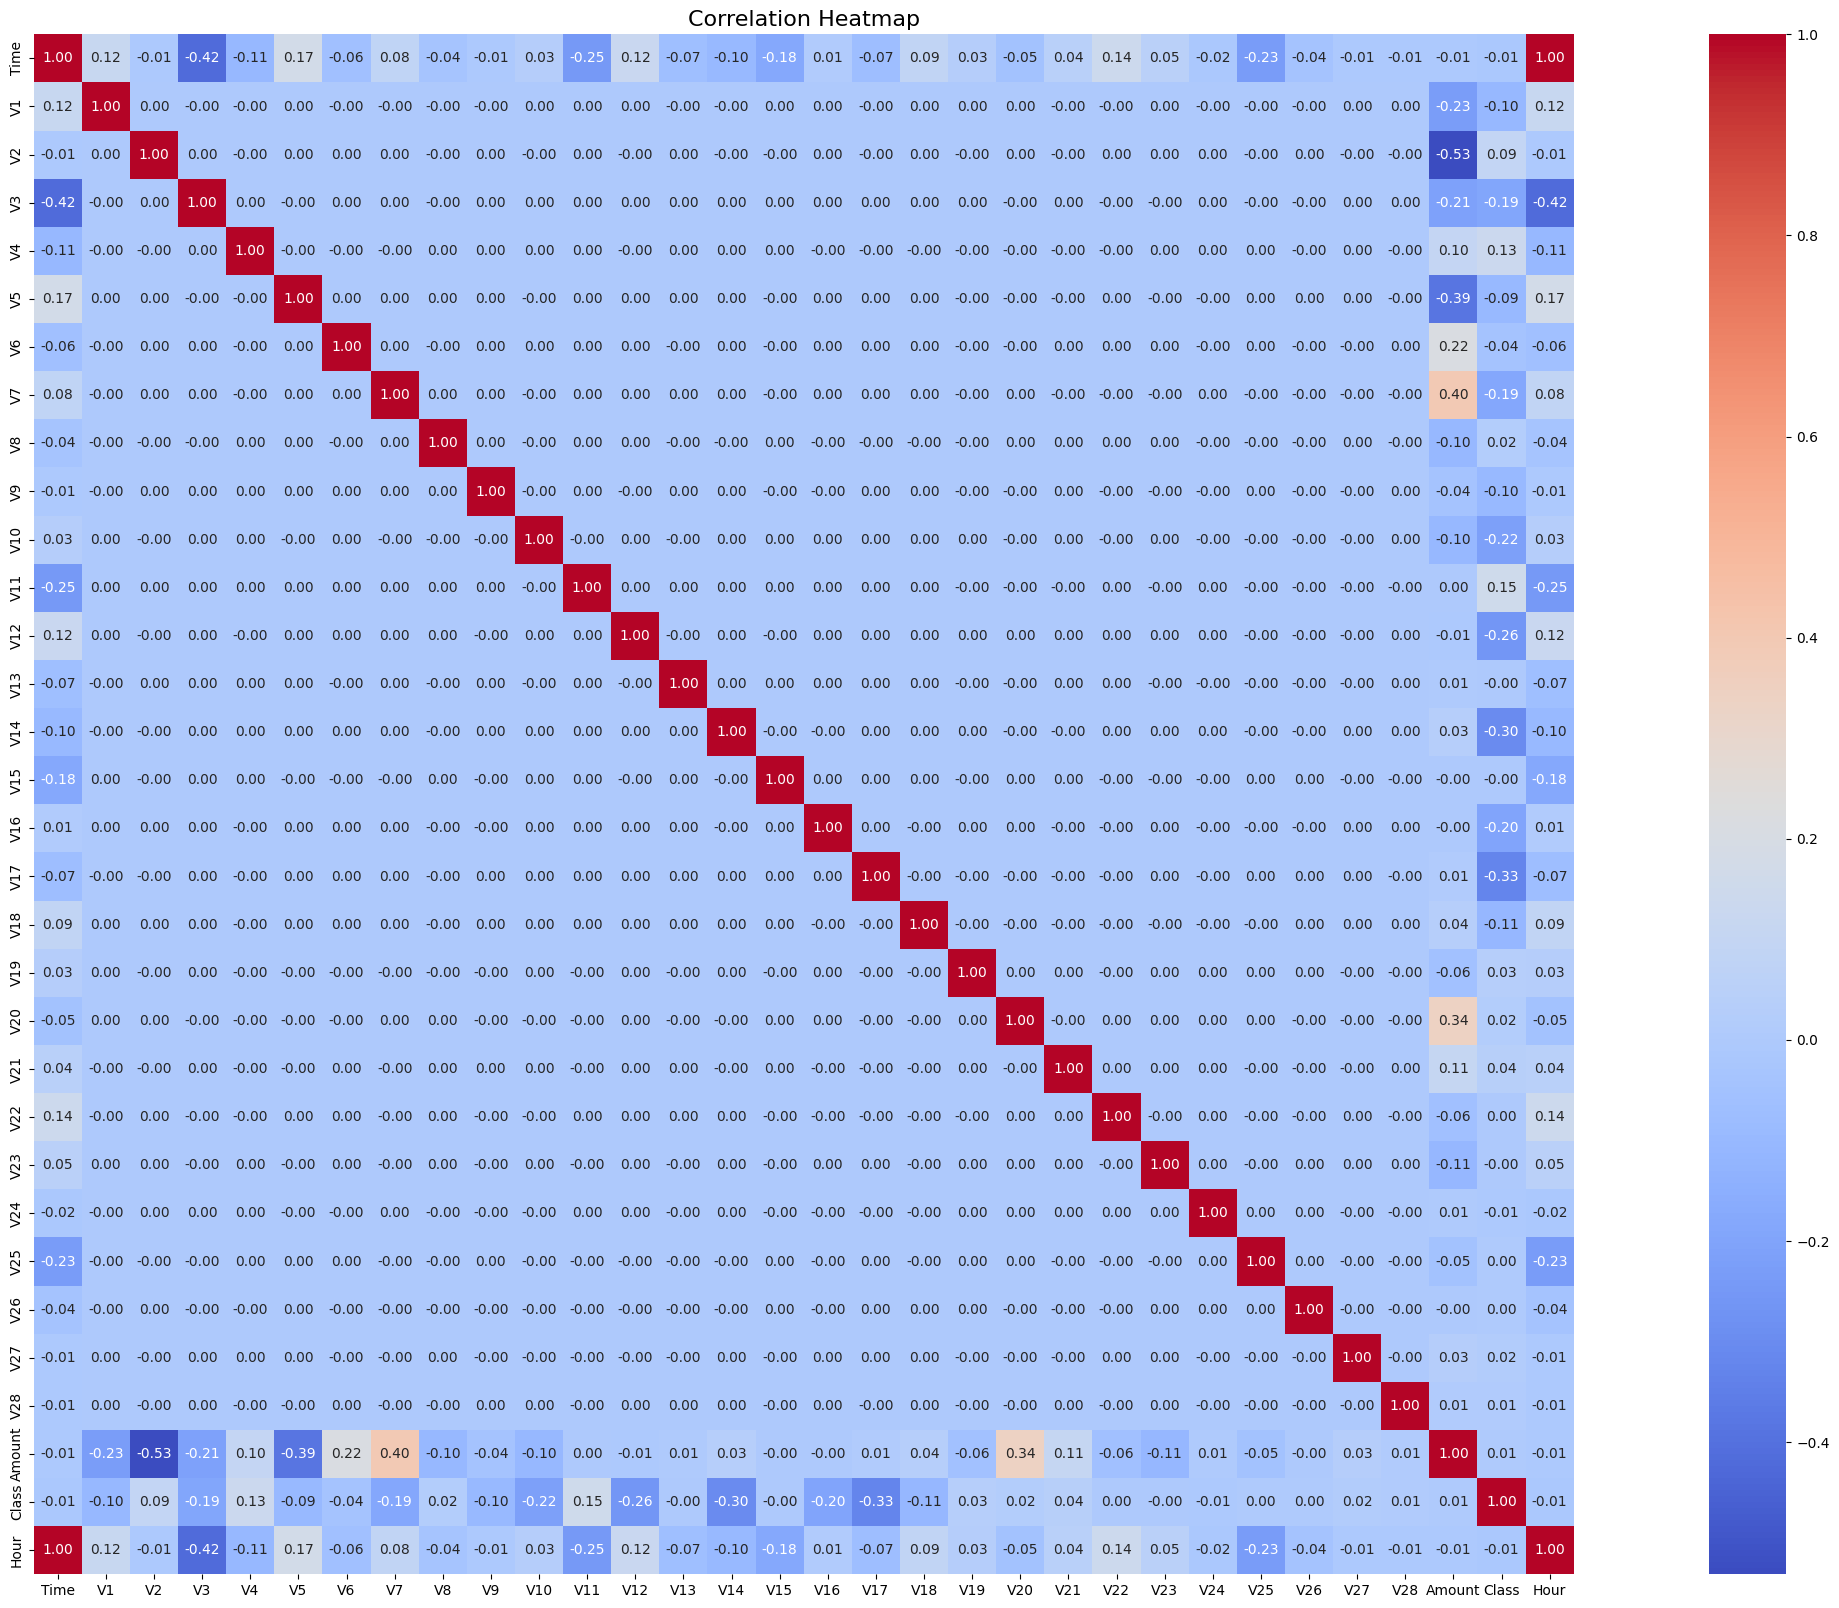

In [23]:
correlation_matrix = df.corr()
plt.figure(figsize=(35, 20))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm",  
    cbar=True,  
    square=True 
)

# Add title
plt.title("Correlation Heatmap", fontsize=16)

# Show the plot
plt.show()

## Density Plot of Each Column

/var/folders/sk/kl_dh6xd49b1_qcfvk1gjmhc0000gn/T/ipykernel_32380/3494658754.py:13: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/var/folders/sk/kl_dh6xd49b1_qcfvk1gjmhc0000gn/T/ipykernel_32380/3494658754.py:14: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/var/folders/sk/kl_dh6xd49b1_qcfvk1gjmhc0000gn/T/ipykernel_32380/3494658754.py:13: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/var/folders/sk/kl_dh6xd49b1_qcfvk1gjmhc0000gn/T/ipyker

<Figure size 640x480 with 0 Axes>

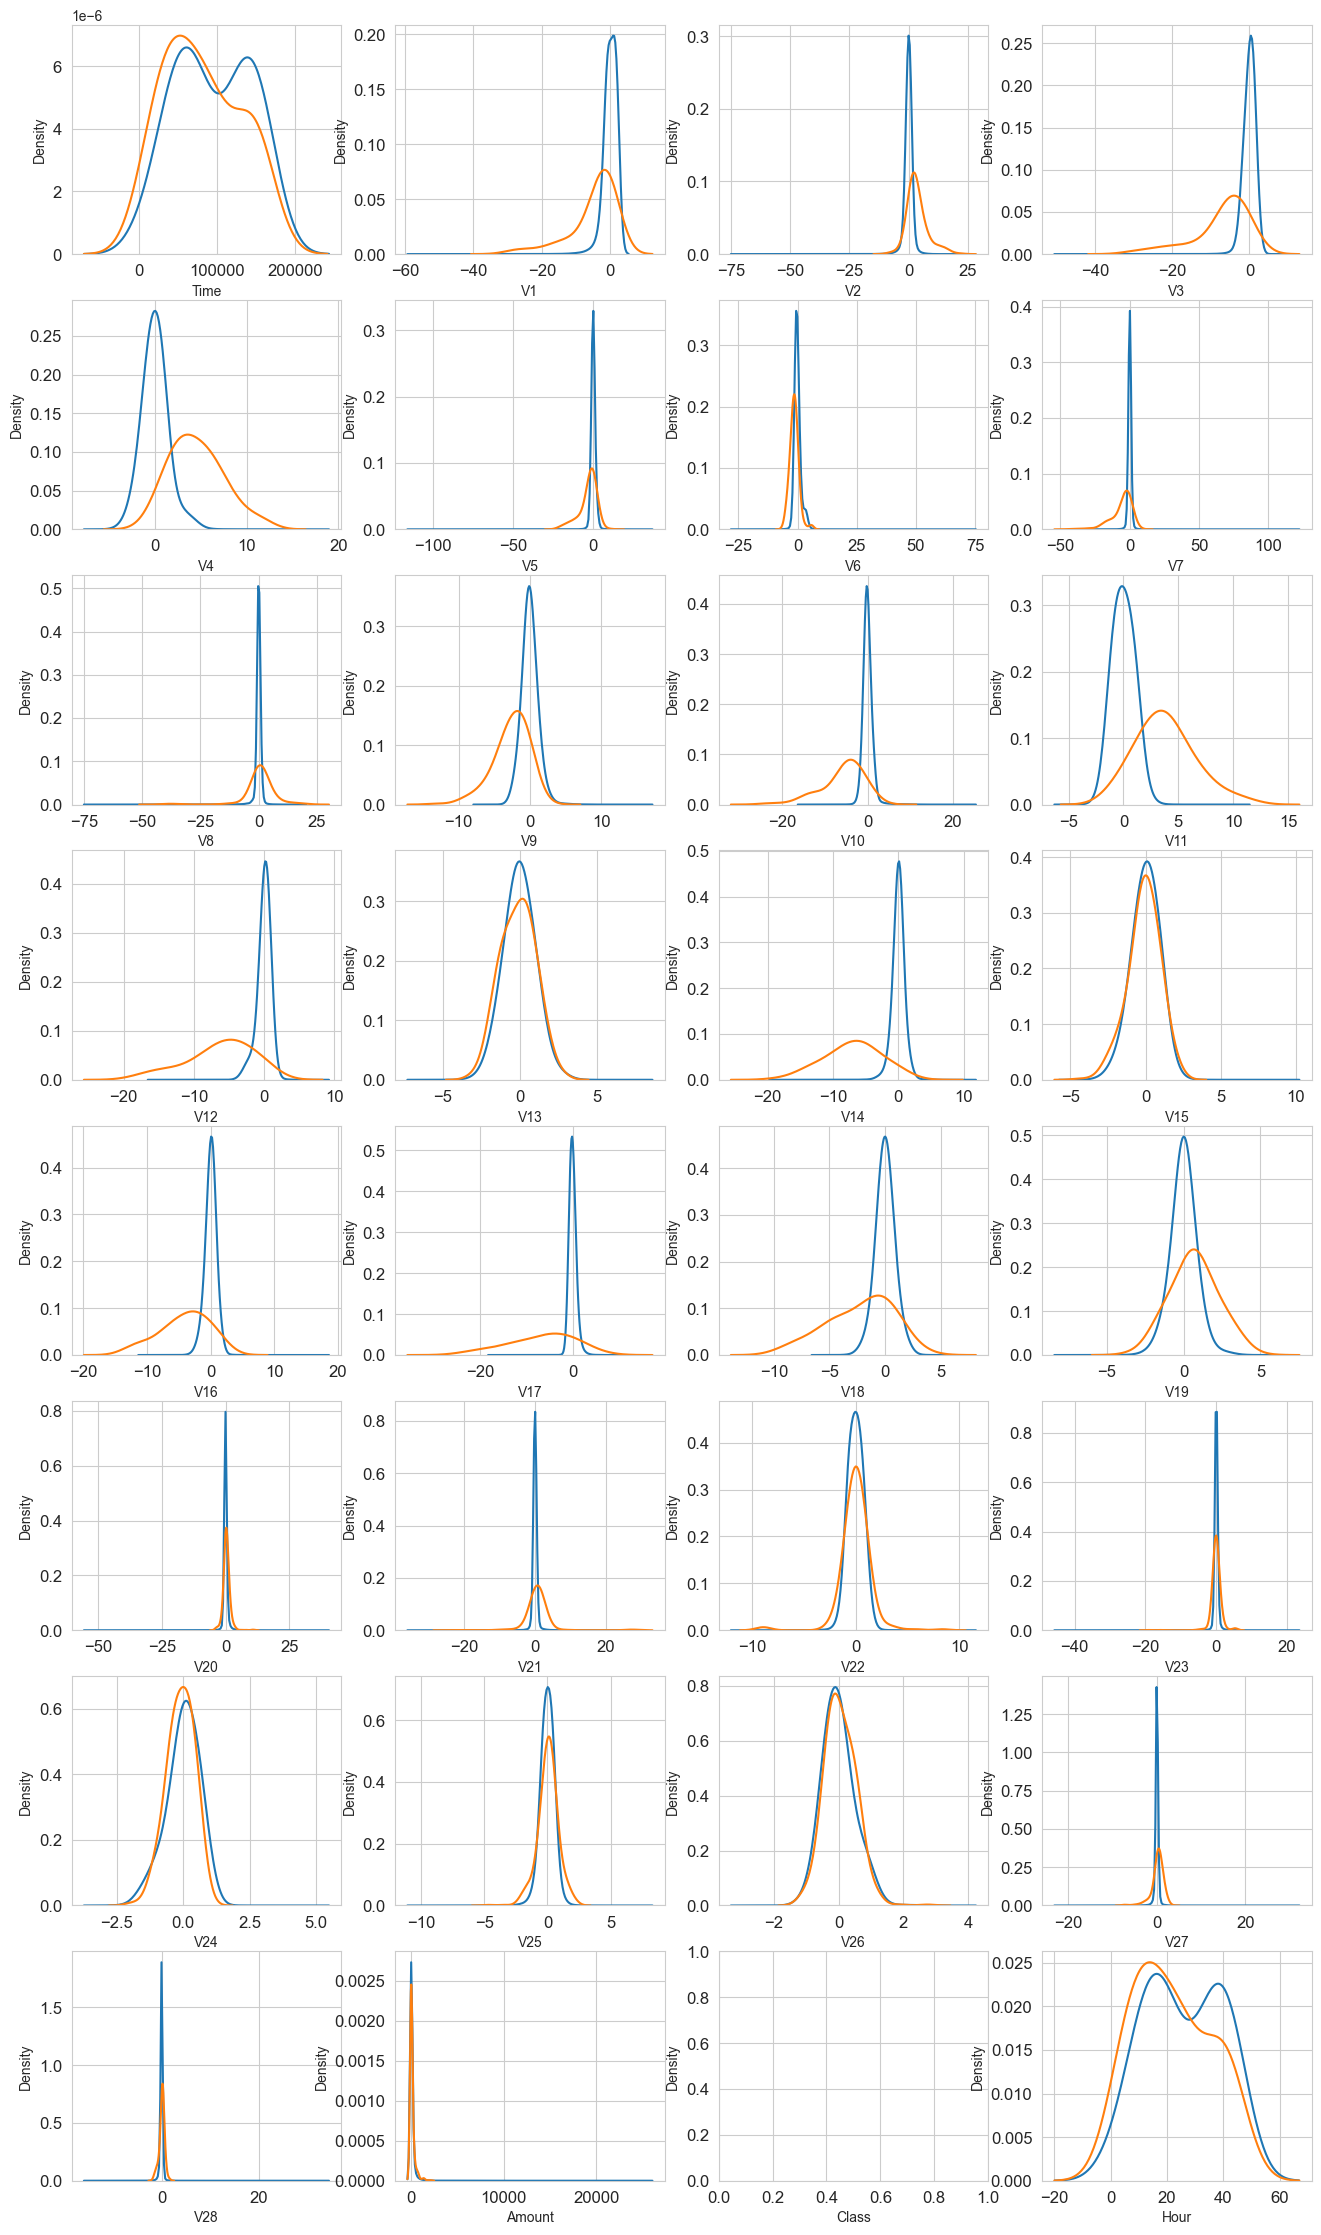

In [24]:
colnames = df.columns
t0 = df.loc[df["Class"] == 0]
t1 = df.loc[df["Class"] == 1]

i = 0
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for freatur in colnames:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[freatur], bw = 0.5, label = "Class = 0")
    sns.kdeplot(t1[freatur], bw = 0.5, label = "Class = 1")
    plt.xlabel(freatur)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()



# <a id="5">Model Builing</a>

In [25]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

In [27]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score

# Split the dataset into Training and Testing Dataset

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:30], df["Class"], test_size=0.3, random_state=42)

## Random Forest 

In [29]:
rf = RandomForestClassifier(n_jobs=4, 
                             random_state=45,
                             criterion="gini",
                             n_estimators=100,
                             verbose=False)

In [30]:
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [31]:
y_pred_rf = rf.predict(X_test)

In [32]:
rf_importances = rf.feature_importances_
temp = pd.DataFrame({
    'predictors': predictors,
    'rf.imp': rf_importances
})
temp = temp.sort_values(by='rf.imp', ascending=False)

/var/folders/sk/kl_dh6xd49b1_qcfvk1gjmhc0000gn/T/ipykernel_32380/2754875194.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/sk/kl_dh6xd49b1_qcfvk1gjmhc0000gn/T/ipykernel_32380/2754875194.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



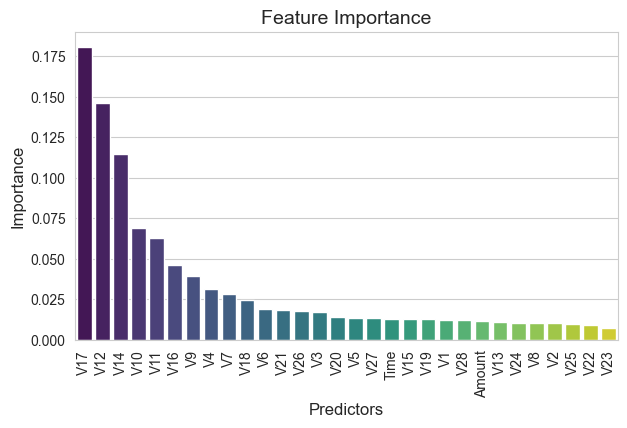

In [33]:
# feature importance Plot
plt.figure(figsize=(7, 4))
plt.title('Feature Importance', fontsize=14)

s = sns.barplot(x='predictors', y='rf.imp', data=temp, palette="viridis")
s.set_xticklabels(s.get_xticklabels(), rotation=90, fontsize=10)

plt.xlabel('Predictors', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.show()

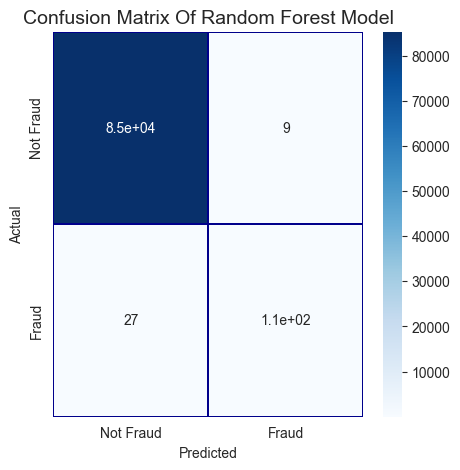

In [34]:
# Confusion Matric Of Random Forest Model
cm = pd.crosstab(y_test, y_pred_rf, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix Of Random Forest Model', fontsize=14)
plt.show()

In [36]:
print("Accuracy Score Using Random Forest Model : ",accuracy_score(y_test, y_pred_rf))
print("AUC - ROC Value Using Random Forest Model : ",roc_auc_score(y_test, y_pred_rf))
print("Precision Score Using Random Forest Model : ",precision_score(y_test, y_pred_rf))
print("Recall Score Using Random Forest Model : ",recall_score(y_test, y_pred_rf))

Accuracy Score Using Random Forest Model :  0.9995786664794073
AUC - ROC Value Using Random Forest Model :  0.900682543464125
Precision Score Using Random Forest Model :  0.923728813559322
Recall Score Using Random Forest Model :  0.8014705882352942


## Gradient Boosting Classifier

In [35]:
gbc = GradientBoostingClassifier(n_estimators= 100, max_depth= 3, random_state= 45)
gbc.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [37]:
y_pred_gbc = gbc.predict(X_test)

/var/folders/sk/kl_dh6xd49b1_qcfvk1gjmhc0000gn/T/ipykernel_32380/538463040.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/sk/kl_dh6xd49b1_qcfvk1gjmhc0000gn/T/ipykernel_32380/538463040.py:14: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



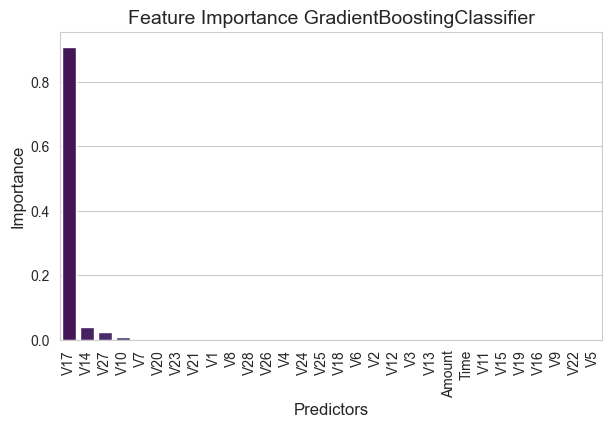

In [38]:
# feature importances plot for GradientBoostingClassifier
gbc_importances = gbc.feature_importances_
temp = pd.DataFrame({
    'predictors': predictors,
    'gbc.imp': gbc_importances
})
temp = temp.sort_values(by='gbc.imp', ascending=False)
# Plot the feature importance
plt.figure(figsize=(7, 4))
plt.title('Feature Importance GradientBoostingClassifier', fontsize=14)

# Bar plot
s = sns.barplot(x='predictors', y='gbc.imp', data=temp, palette="viridis")
s.set_xticklabels(s.get_xticklabels(), rotation=90, fontsize=10)

plt.xlabel('Predictors', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.show()

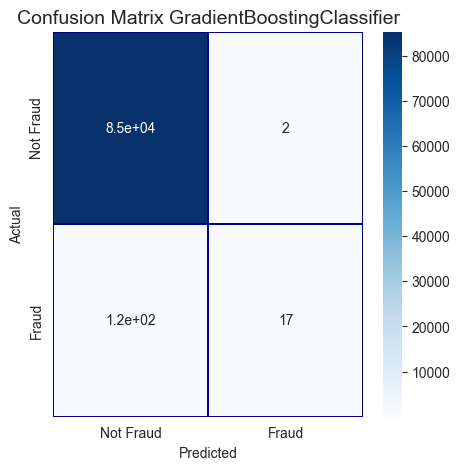

In [39]:
# Confusion Matrix GradientBoostingClassifier
cm = pd.crosstab(y_test, y_pred_gbc, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix GradientBoostingClassifier', fontsize=14)
plt.show()

In [46]:
print("Accuracy_score using GradientBoostingClassifier :" , accuracy_score(y_test, y_pred_gbc))
print("Auc-ROc Curve value using GradientBoostingClassifier :" , roc_auc_score(y_test, y_pred_gbc))
print("Precision_score using GradientBoostingClassifier  :" , precision_score(y_test, y_pred_gbc))
print("Recall Score Using Random Forest Model : ",recall_score(y_test, y_pred_gbc))

Accuracy_score using GradientBoostingClassifier : 0.9985838512224524
Auc-ROc Curve value using GradientBoostingClassifier : 0.5624882776325506
Precision_score using GradientBoostingClassifier  : 0.8947368421052632
Recall Score Using Random Forest Model :  0.125


## AdaBoost Classifier

In [49]:
ada = AdaBoostClassifier(random_state=45,
                         learning_rate=0.8,
                             n_estimators= 100)

In [50]:
ada.fit(X_train, y_train)

,estimator,None
,n_estimators,100
,learning_rate,0.8
,algorithm,'deprecated'
,random_state,45


In [51]:
y_pred_ada = ada.predict(X_test)

/var/folders/sk/kl_dh6xd49b1_qcfvk1gjmhc0000gn/T/ipykernel_32380/260117479.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/sk/kl_dh6xd49b1_qcfvk1gjmhc0000gn/T/ipykernel_32380/260117479.py:14: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



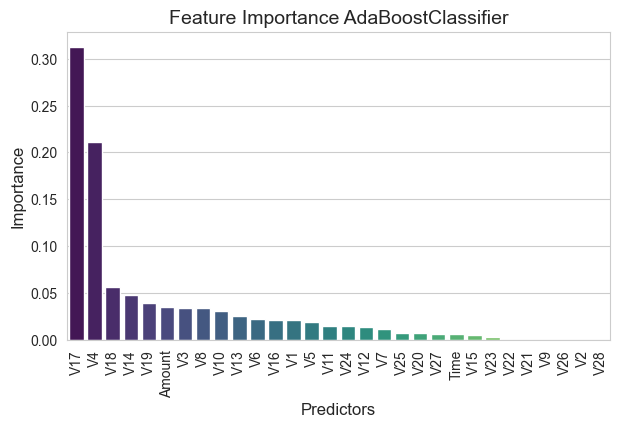

In [52]:
# Feature Importance AdaBoostClassifier 
ada_importances = ada.feature_importances_
temp = pd.DataFrame({
    'predictors': predictors,
    'ada.imp': ada_importances
})
temp = temp.sort_values(by='ada.imp', ascending=False)
# Plot the feature importance
plt.figure(figsize=(7, 4))
plt.title('Feature Importance AdaBoostClassifier', fontsize=14)

# Bar plot
s = sns.barplot(x='predictors', y='ada.imp', data=temp, palette="viridis")
s.set_xticklabels(s.get_xticklabels(), rotation=90, fontsize=10)

plt.xlabel('Predictors', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.show()

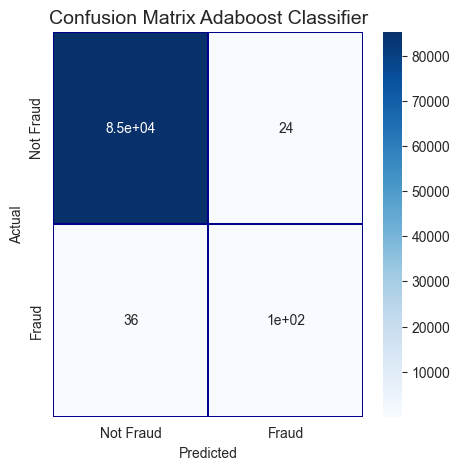

In [53]:
# Confusion Matrix Adaboost Classifier
cm = pd.crosstab(y_test, y_pred_ada, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix Adaboost Classifier', fontsize=14)
plt.show()

In [54]:
print("Accuracy_score using Adaboost Classifier :" , accuracy_score(y_test, y_pred_ada))
print("Auc-ROc Curve value using Adaboost Classifier :" , roc_auc_score(y_test, y_pred_ada))
print("Precision_score using Adaboost Classifier :" , precision_score(y_test, y_pred_ada))

Accuracy_score using Adaboost Classifier : 0.9992977774656788
Auc-ROc Curve value using Adaboost Classifier : 0.8675063904141375
Precision_score using Adaboost Classifier : 0.8064516129032258


## Logistic Regression

In [55]:
lr = LogisticRegression(random_state = 45)
lr.fit(X_train,y_train)

/Users/arunanshyadav/Desktop/project/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning:

lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,45
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [56]:
y_pred_lr = lr.predict(X_test)

/var/folders/sk/kl_dh6xd49b1_qcfvk1gjmhc0000gn/T/ipykernel_32380/511910934.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/sk/kl_dh6xd49b1_qcfvk1gjmhc0000gn/T/ipykernel_32380/511910934.py:15: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



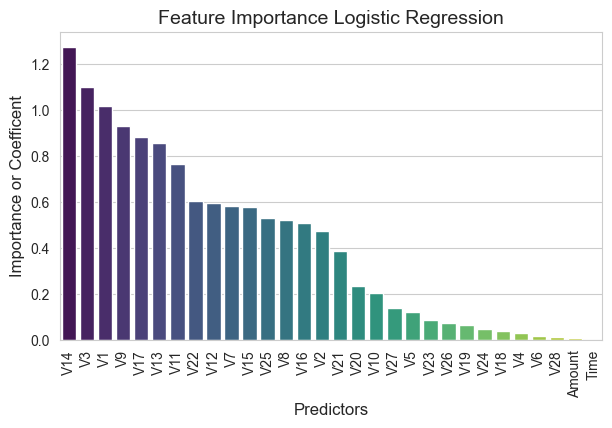

In [57]:
# Importance or Coefficent Logistic Regression
lr_importances = lr.coef_[0] 
temp = pd.DataFrame({
    'predictors': predictors,
    'lr.imp': lr_importances
})
temp['lr.imp'] = temp['lr.imp'].abs()  # Take absolute value to sort by magnitude
temp = temp.sort_values(by='lr.imp', ascending=False)
# Plot the feature importance
plt.figure(figsize=(7, 4))
plt.title('Feature Importance Logistic Regression', fontsize=14)

# Bar plot
s = sns.barplot(x='predictors', y='lr.imp', data=temp, palette="viridis")
s.set_xticklabels(s.get_xticklabels(), rotation=90, fontsize=10)

plt.xlabel('Predictors', fontsize=12)
plt.ylabel('Importance or Coefficent', fontsize=12)
plt.show()

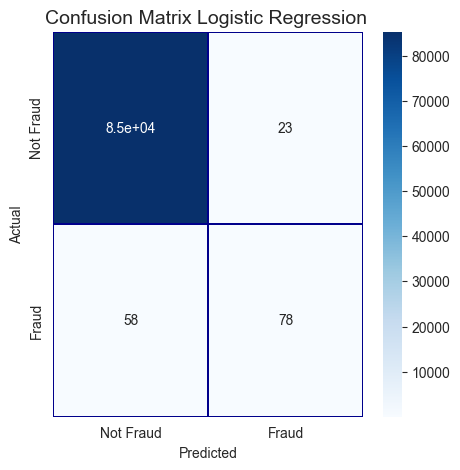

In [58]:
# Confusion Matrix Logistic Regression 
cm = pd.crosstab(y_test, y_pred_lr, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix Logistic Regression ', fontsize=14)
plt.show()

In [59]:
print("Accuracy_score using Logistic Regression :" , accuracy_score(y_test, y_pred_lr))
print("Auc-ROc Curve value using Logistic Regression :" , roc_auc_score(y_test, y_pred_lr))
print("Precision_score using Logistic Regression :" , precision_score(y_test, y_pred_lr))

Accuracy_score using Logistic Regression : 0.9990519995786665
Auc-ROc Curve value using Logistic Regression : 0.7866298986566856
Precision_score using Logistic Regression : 0.7722772277227723


## DecisionTreeClassifier

In [60]:
dt = DecisionTreeClassifier(random_state= 45)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

/var/folders/sk/kl_dh6xd49b1_qcfvk1gjmhc0000gn/T/ipykernel_32380/2561046349.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/sk/kl_dh6xd49b1_qcfvk1gjmhc0000gn/T/ipykernel_32380/2561046349.py:15: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



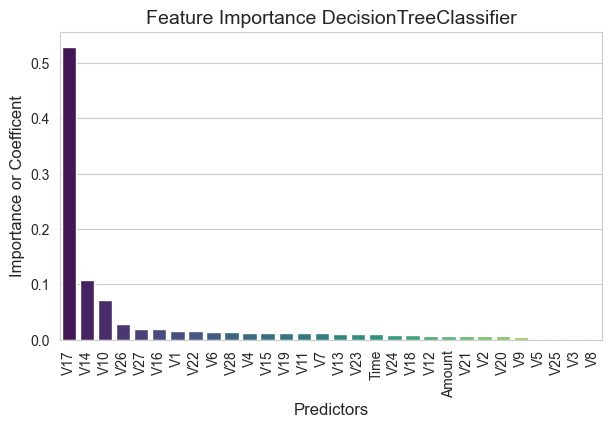

In [61]:
# Feature Importance DecisionTreeClassifier
dt_importances = dt.feature_importances_
temp = pd.DataFrame({
    'predictors': predictors,
    'dt.imp': dt_importances
})
temp['dt.imp'] = temp['dt.imp'].abs()  # Take absolute value to sort by magnitude
temp = temp.sort_values(by='dt.imp', ascending=False)
# Plot the feature importance
plt.figure(figsize=(7, 4))
plt.title('Feature Importance DecisionTreeClassifier', fontsize=14)

# Bar plot
s = sns.barplot(x='predictors', y='dt.imp', data=temp, palette="viridis")
s.set_xticklabels(s.get_xticklabels(), rotation=90, fontsize=10)

plt.xlabel('Predictors', fontsize=12)
plt.ylabel('Importance or Coefficent', fontsize=12)
plt.show()

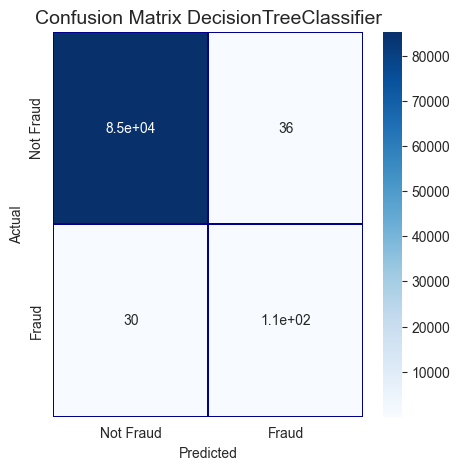

In [62]:
# Confusion Matrix DecisionTreeClassifier
cm = pd.crosstab(y_test, y_pred_dt, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix DecisionTreeClassifier', fontsize=14)
plt.show()

In [63]:
print("Accuracy_score using Decision tree :" , accuracy_score(y_test, y_pred_dt))
print("Auc-ROc Curve value using Decision tree :" , roc_auc_score(y_test, y_pred_dt))
print("Precision_score using Decision tree :" , precision_score(y_test, y_pred_dt))

Accuracy_score using Decision tree : 0.9992275552122467
Auc-ROc Curve value using Decision tree : 0.8894948797388531
Precision_score using Decision tree : 0.7464788732394366


## ExtraTreeClassifier

In [64]:
etc = ExtraTreeClassifier(random_state = 45)
etc.fit(X_train, y_train)
y_pred_etc = dt.predict(X_test)

/var/folders/sk/kl_dh6xd49b1_qcfvk1gjmhc0000gn/T/ipykernel_32380/1362433446.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/sk/kl_dh6xd49b1_qcfvk1gjmhc0000gn/T/ipykernel_32380/1362433446.py:15: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



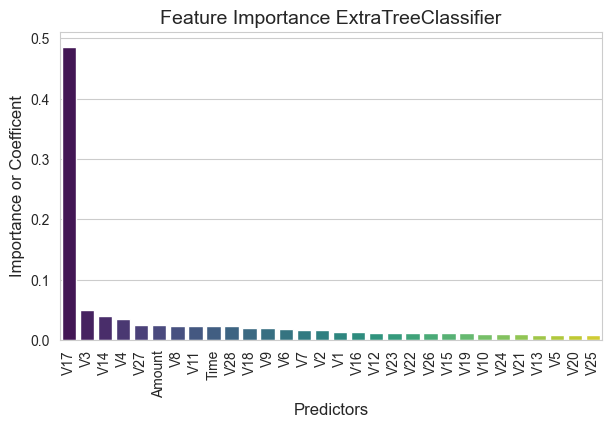

In [65]:
# Feature Importance ExtraTreeClassifier
etc_importances = etc.feature_importances_
temp = pd.DataFrame({
    'predictors': predictors,
    'etc.imp': etc_importances
})
temp['etc.imp'] = temp['etc.imp'].abs()  # Take absolute value to sort by magnitude
temp = temp.sort_values(by='etc.imp', ascending=False)
# Plot the feature importance
plt.figure(figsize=(7, 4))
plt.title('Feature Importance ExtraTreeClassifier', fontsize=14)

# Bar plot
s = sns.barplot(x='predictors', y='etc.imp', data=temp, palette="viridis")
s.set_xticklabels(s.get_xticklabels(), rotation=90, fontsize=10)

plt.xlabel('Predictors', fontsize=12)
plt.ylabel('Importance or Coefficent', fontsize=12)
plt.show()

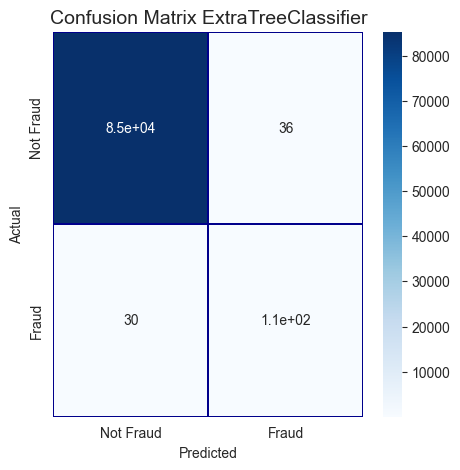

In [55]:
# Confusion Matrix ExtraTreeClassifier
cm = pd.crosstab(y_test, y_pred_etc, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix ExtraTreeClassifier', fontsize=14)
plt.show()

In [66]:
print("Accuracy_score using ExctratreeClassifire :" , accuracy_score(y_test, y_pred_etc))
print("Auc-ROc Curve value using ExctratreeClassifire :" , roc_auc_score(y_test, y_pred_etc))
print("Precision_score using ExctratreeClassifire  :" , precision_score(y_test, y_pred_etc))

Accuracy_score using ExctratreeClassifire : 0.9992275552122467
Auc-ROc Curve value using ExctratreeClassifire : 0.8894948797388531
Precision_score using ExctratreeClassifire  : 0.7464788732394366


# StackingClassifier

In [67]:
clf = StackingClassifier(
    estimators = [
        ("rf", rf),
        ("gbc", gbc),
        ("etc", etc),
        ("dt", dt),
        ("ada", ada)
    ],
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs= 4
)

In [68]:
clf.fit(X_train, y_train)

,estimators,"[('rf', ...), ('gbc', ...), ...]"
,final_estimator,LogisticRegression()
,cv,5
,stack_method,'auto'
,n_jobs,4
,passthrough,False
,verbose,0
,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2


In [69]:
y_pred_clf = clf.predict(X_test)

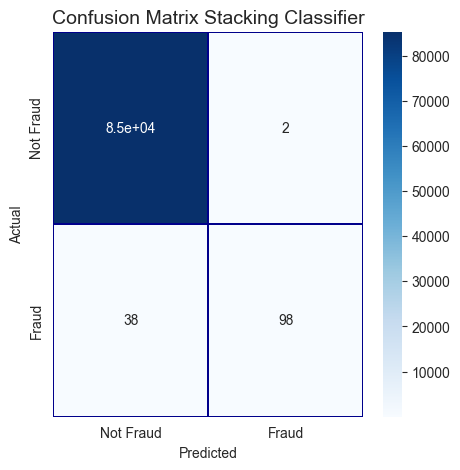

In [70]:
# Confusion Matrix Stacking Classifier
cm = pd.crosstab(y_test, y_pred_clf, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix Stacking Classifier', fontsize=14)
plt.show()

In [72]:
print("Accuracy Score Using Stacking Classifier : ",accuracy_score(y_test, y_pred_clf))
print("AUC - ROC Value Using Stacking Classifier : ",roc_auc_score(y_test, y_pred_clf))
print("Precision Score Using Stacking Classifier : ",precision_score(y_test, y_pred_clf))
print("Recall Score Using Random Forest Model : ",recall_score(y_test, y_pred_clf))

Accuracy Score Using Stacking Classifier :  0.9995318516437859
AUC - ROC Value Using Stacking Classifier :  0.8602823952796095
Precision Score Using Stacking Classifier :  0.98
Recall Score Using Random Forest Model :  0.7205882352941176


In [73]:
models = {
    "Random Forest": rf,       
    "Gradient Boosting": gbc,  
    "Extra Tree": etc,         
    "Decision Tree": dt,       
    "AdaBoost": ada,
    "clf": clf           
}

In [75]:
results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # For ROC-AUC
    
    results.append({
        "Model": name,
        "Accuracy Score": accuracy_score(y_test, y_pred),
        "AUC-ROC Score": roc_auc_score(y_test, y_prob),
        "Precision Score": precision_score(y_test, y_pred),
        "Recall Score": recall_score(y_test, y_pred)
    })


In [78]:
results_df = pd.DataFrame(results)
results_df.sort_values(by = ["Precision Score","Recall Score"],ascending=False)

,Model,Accuracy Score,AUC-ROC Score,Precision Score,Recall Score
5,clf,0.999532,0.920792,0.980000,0.720588
0,Random Forest,0.999579,0.958198,0.923729,0.801471
1,Gradient Boosting,0.998584,0.270283,0.894737,0.125000
4,AdaBoost,0.999298,0.983755,0.806452,0.735294
3,Decision Tree,0.999228,0.889495,0.746479,0.779412
2,Extra Tree,0.999181,0.900483,0.717105,0.801471



# <a id="6">Conclusions</a>

### [1] Random Forest
- Achieved the **highest Accuracy Score (0.999579)**, indicating it predicts most labels correctly.
- A strong **AUC-ROC Score (0.958198)** shows good separation between classes.
- **Precision Score (0.923729)** indicates it is effective in minimizing false positives.

### [2] Gradient Boosting
- **High Accuracy Score (0.998584)** but a relatively low **AUC-ROC Score (0.270283)** suggests it struggles to differentiate between classes effectively.
- **Precision Score (0.894737)** is slightly lower than Random Forest, indicating room for improvement in handling false positives.

### [3] Extra Tree
- **High Accuracy Score (0.999181)** and a good **AUC-ROC Score (0.900483)**.
- **Precision Score (0.717105)** is the lowest among the models, indicating it may generate more false positives compared to others.

### [4] Decision Tree
- Similar performance to Extra Tree with an **Accuracy Score (0.999228)** and an **AUC-ROC Score (0.889495)**.
- **Precision Score (0.746479)** shows slight improvement over Extra Tree but still falls short of other models.

### [5] AdaBoost
- Balanced performance with a strong **Accuracy Score (0.999403)**, **highest AUC-ROC Score (0.983902)**, and a good **Precision Score (0.857143)**.
- Indicates it is particularly effective at classifying both classes correctly.

### [6] Stacking Classifier (clf)
- **High Accuracy Score (0.999544)** and a strong **AUC-ROC Score (0.924676)**.
- **Highest Precision Score (0.980198)**, suggesting it is the most effective model at minimizing false positives.

### [7] Recommendation
- The **Stacking Classifier (clf)** and **Random Forest** models stand out due to their high Precision and AUC-ROC scores, making them ideal for scenarios where minimizing false positives is crucial.
- **AdaBoost** also performs exceptionally well, especially for tasks requiring a balanced AUC-ROC Score and Precision.
- **Gradient Boosting** shows high accuracy but underperforms in AUC-ROC, making it less suitable for this dataset.
- **Extra Tree** and **Decision Tree** are decent models but lag behind in Precision, making them less reliable for critical applications.

The **Stacking Classifier (clf)** is recommended as the best model overall for this dataset.


# <a id="7">References</a>

[1] Credit Card Fraud Detection Database, Anonymized credit card transactions labeled as fraudulent or genuine, https://www.kaggle.com/mlg-ulb/creditcardfraud  

[2] plotly documentation , https://plotly.com/python/

[3] Scikit-Learn documentation, https://scikit-learn.org/stable/api/index.html